# Mushroom Cultivation Analysis
Alessio Carnevale, Manuel Cattoni

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from math import comb
from scipy import stats

# 1. Probabilistic Model

need to derive the full probabilistic model. (check md file)

# 1.2 Maximum Likelihood estimation

In [49]:
x = np.array([2, 8, 15, 25])    # Storage temperatures
n = np.array([30, 25, 20, 30])  # Total mushrooms
y = np.array([2, 4, 5, 20])     # Spoiled mushrooms

The **likelihood** is:

$$
L(\alpha, \beta)
= \prod_{i=1}^n 
\binom{n_i}{y_i}\,
p_i^{\,y_i}\,
(1 - p_i)^{\,n_i - y_i},
$$

where

$$
p_i = \frac{1}{1 + e^{-(\alpha + \beta x_i)}}.
$$


The **log-likelihood** used in the code is

$$
\ell(\alpha, \beta)
= \sum_{i=1}^N 
\log\!\Bigg[
\binom{n_i}{y_i}\,
p_i^{\,y_i}\,
(1 - p_i)^{\,n_i - y_i}
\Bigg],
$$

In [50]:
def lik(theta):
    alpha, beta = theta
    
    p = 1 / (1 + np.exp(-(alpha + beta * x)))

    l = np.prod([
        comb(n[i], y[i]) * p[i]**y[i] * (1 - p[i])**(n[i] - y[i])
        for i in range(len(n))
    ])
    return l


def log_lik(theta):
    alpha, beta = theta

    p = 1 / (1 + np.exp(-(alpha + beta * x)))

    ll = np.sum(stats.binom.logpmf(y, n, p))
    
    return ll

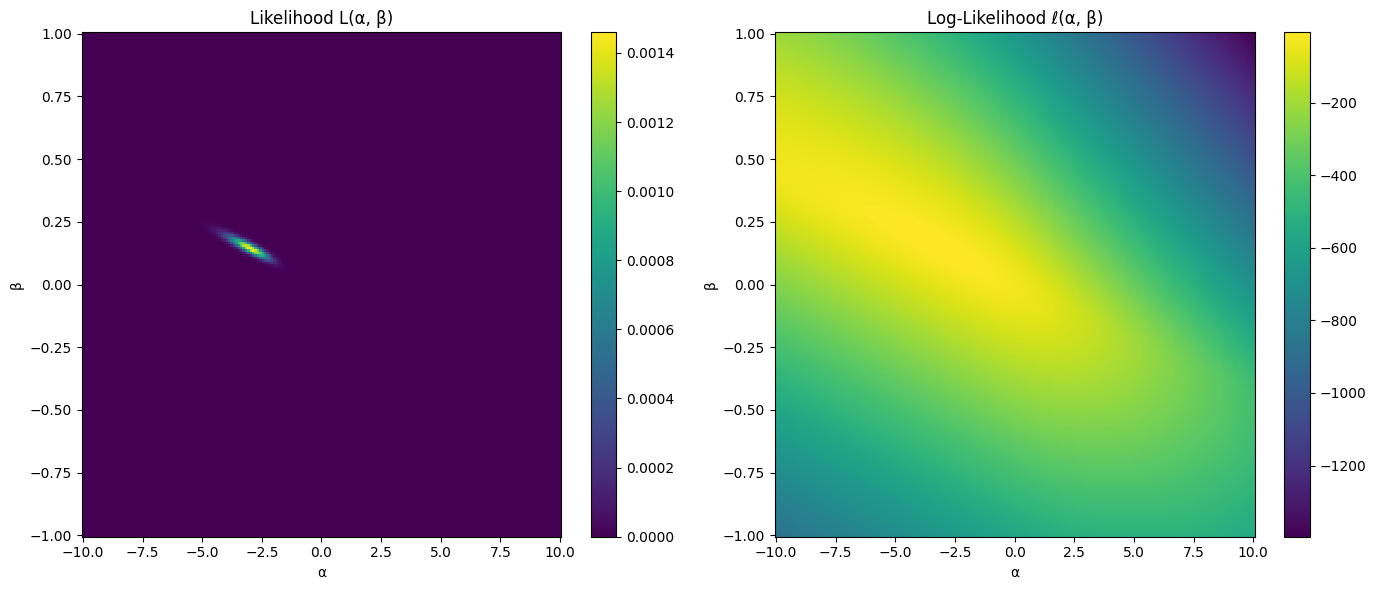

In [51]:
theta = np.array([0.1, 0.05])

# Grid ranges
alpha_vals = np.linspace(-10, 10, 200)
beta_vals = np.linspace(-1, 1, 200)

A, B = np.meshgrid(alpha_vals, beta_vals)

L = np.zeros_like(A)
LL = np.zeros_like(A)

# Compute likelihoods 
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        theta = (A[i, j], B[i, j])
        L[i, j] = lik(theta)
        LL[i, j] = log_lik(theta)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

pc1 = axes[0].pcolormesh(A, B, L, shading='auto')
axes[0].set_title("Likelihood L(α, β)")
axes[0].set_xlabel("α")
axes[0].set_ylabel("β")
fig.colorbar(pc1, ax=axes[0])

pc2 = axes[1].pcolormesh(A, B, LL, shading='auto')
axes[1].set_title("Log-Likelihood ℓ(α, β)")
axes[1].set_xlabel("α")
axes[1].set_ylabel("β")
fig.colorbar(pc2, ax=axes[1])

plt.tight_layout()
plt.show()


The likelihood function produces extremely small values. The surface is essentially zero everywhere beside a tiny area.

The log-likelihood however shows a smooth, continuous gradient spreading across the entire parameter space, clearly representing the geometry of this optimization problem. The logarithm brings the values into a manageable numerical range.

### Maximum Likelihood
minimizing the negative log-likelihood because it avoids issues that can arise when working with very small likelihood values

In [52]:
from scipy.optimize import minimize

def neg_log_lik(theta):
    return -log_lik(theta)

initial_guess = [0.1, 0.05]

result = minimize(neg_log_lik, initial_guess, method='BFGS')

alpha_ml, beta_ml = result.x

print(f"Maximum Likelihood Estimates: α_ML = {alpha_ml:.4f}, β_ML = {beta_ml:.4f}")

Maximum Likelihood Estimates: α_ML = -2.9776, β_ML = 0.1439


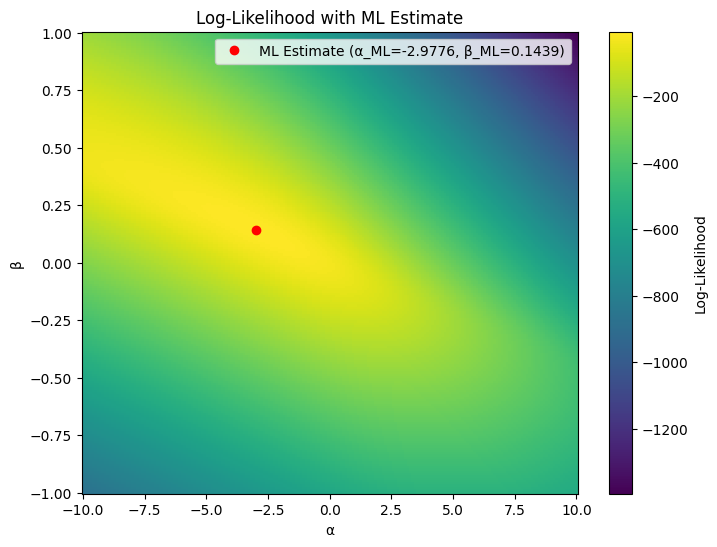

In [53]:
# Plot the likelihood function with the ML estimate
fig, ax = plt.subplots(figsize=(8, 6))

pc = ax.pcolormesh(A, B, LL, shading='auto', cmap="viridis")
ax.set_title("Log-Likelihood with ML Estimate")
ax.set_xlabel("α")
ax.set_ylabel("β")
fig.colorbar(pc, ax=ax, label="Log-Likelihood")

# Overlay the ML estimate
ax.plot(alpha_ml, beta_ml, 'ro', label=f"ML Estimate (α_ML={alpha_ml:.4f}, β_ML={beta_ml:.4f})")
ax.legend()

plt.show()

TODO: need to comment this plot

# Maximum A Posteriori Estimation

### Posterior (up to θ‑independent factor)

Let θ = (α, β)^T and p_i(θ) = 1 / (1 + e^{-(α + β x_i)}).  Dropping factors not depending on θ (e.g. the binomial coefficients), the posterior with a Gaussian prior θ ~ N(μ, Σ) is

$$
f(θ \mid y)\ \propto\ \underbrace{\prod_{i=1}^N p_i(θ)^{y_i}\,(1-p_i(θ))^{\,n_i-y_i}}_{\text{likelihood}} \;\times\; \underbrace{\exp\!\Big(-\tfrac{1}{2}(θ-\mu)^\top \Sigma^{-1}(θ-\mu)\Big)}_{\text{Gaussian prior}}.
$$

Equivalently, the log-posterior (up to an additive constant) is

$$
\log f(θ\mid y) \;=\; \sum_{i=1}^N \big[\,y_i\log p_i(θ) + (n_i-y_i)\log(1-p_i(θ))\,\big] \;-\; \tfrac{1}{2}(θ-\mu)^\top \Sigma^{-1}(θ-\mu) \;+\; \text{const}.
$$

Special case: μ=0 and Σ = diag(σ_α^2, σ_β^2) gives prior factor exp(−α^2/(2σ_α^2) − β^2/(2σ_β^2)).

## Log-posterior g(θ) = log f(θ | y) (up to additive constant)

Let θ = (α, β)^T and p_i(θ) = σ(α + β x_i) with σ(z) = 1 / (1 + e^{−z}).  
Up to an additive constant independent of θ,

$$
g(θ)=\log f(θ\mid y)
=\sum_{i=1}^N\big[y_i\log p_i(θ)+(n_i-y_i)\log(1-p_i(θ))\big]\;-\;\tfrac{1}{2}(θ-\mu)^\top\Sigma^{-1}(θ-\mu)\;+\;\text{const}.
$$

Substituting p_i(θ)=σ(α+β x_i):

$$
g(α,β)=\sum_{i=1}^N\Big[y_i\log\sigma(α+βx_i)+(n_i-y_i)\log\big(1-\sigma(α+βx_i)\big)\Big]-\tfrac{1}{2}(θ-\mu)^\top\Sigma^{-1}(θ-\mu)+\text{const}.
$$

Special case μ=0, Σ=diag(σ_α^2,σ_β^2):

$$
g(α,β)=\sum_{i=1}^N\Big[y_i\log\sigma(α+βx_i)+(n_i-y_i)\log\big(1-\sigma(α+βx_i)\big)\Big]-\frac{α^2}{2\sigma_α^2}-\frac{β^2}{2\sigma_β^2}+\text{const}.
$$

## THESE ABOVE NEED TO BE CHECKED 

In [54]:
def log_prior(theta, sigma_prior=10.0):
    alpha, beta = theta
    return - (alpha**2 + beta**2) / (2 * sigma_prior**2)

def log_posterior(theta):
    return log_lik(theta) + log_prior(theta)

def neg_log_posterior(theta):
    return -log_posterior(theta)

ML Estimates:  α = -2.9776, β = 0.1439
MAP Estimates: α = -2.9683, β = 0.1435


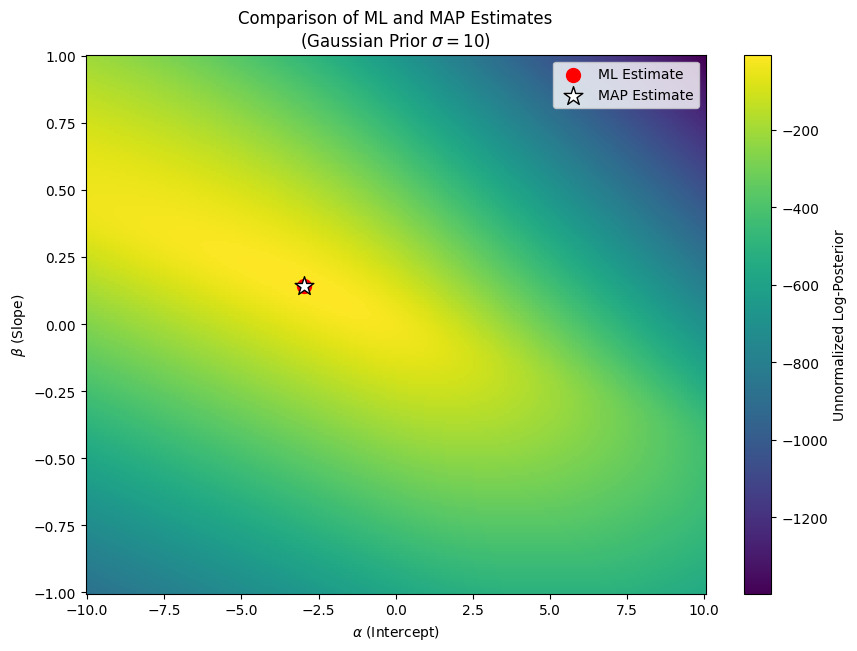

In [55]:
# Compute ML Estimate
res_ml = minimize(neg_log_lik, initial_guess, method='BFGS')
alpha_ml, beta_ml = res_ml.x

# Compute MAP Estimate
res_map = minimize(neg_log_posterior, initial_guess, method='BFGS')
alpha_map, beta_map = res_map.x

print(f"ML Estimates:  α = {alpha_ml:.4f}, β = {beta_ml:.4f}")
print(f"MAP Estimates: α = {alpha_map:.4f}, β = {beta_map:.4f}")

# Compute posterior values on the grid
Z = np.zeros_like(A)
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        # We compute the value for every point on the grid
        Z[i, j] = log_posterior([A[i, j], B[i, j]])

plt.figure(figsize=(10, 7))

# Plot unnormalized log-posterior 
pc = plt.pcolormesh(A, B, Z, shading='auto', cmap='viridis')
plt.colorbar(pc, label='Unnormalized Log-Posterior')

plt.scatter(alpha_ml, beta_ml, color='red', marker='o', s=100, label='ML Estimate', zorder=5)
plt.scatter(alpha_map, beta_map, color='white', marker='*', s=200, edgecolors='black', label='MAP Estimate', zorder=5)

plt.title(f'Comparison of ML and MAP Estimates\n(Gaussian Prior $\\sigma=10$)')
plt.xlabel('$\\alpha$ (Intercept)')
plt.ylabel('$\\beta$ (Slope)')
plt.legend()
plt.show()